In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [4]:
from soundsig.sound import BioSound 

### Collect data

In [5]:
DATASET_ID = 'bengalese_finch_sober'

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf-audio.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/bengalese_finch_sober/bf-audio.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df["syll_len"] = syllable_df.end_time - syllable_df.start_time

In [9]:
len(syllable_df)

215663

In [10]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,audio,rate,spectrogram,syll_len
0,1.058250,1.089219,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,"[0.12828393, 0.060129583, -0.21070328, 0.00274...",32000,"[[5, 5, 5, 5, 3, 25, 26, 75, 105, 80, 47, 16, ...",0.030969
1,2.058187,2.117165,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,"[0.0013724383, 0.11671471, 0.033512227, 0.0607...",32000,"[[4, 4, 4, 4, 16, 8, 6, 11, 7, 3, 3, 14, 51, 2...",0.058978
2,2.234500,2.285938,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,"[0.07955982, 0.05747984, 0.042854592, 0.059728...",32000,"[[2, 2, 2, 3, 0, 26, 49, 12, 9, 2, 2, 93, 68, ...",0.051438


In [11]:
syllable_df['nsamp'] = [len(row.audio) for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df))]

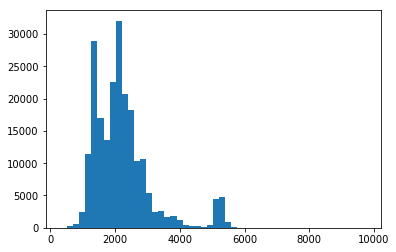

In [12]:
plt.hist(syllable_df['nsamp'].values, bins=50);

In [13]:
def create_Biosound(audio, rate):
    myBioSound = BioSound(soundWave=audio, fs=rate)
    # Calculate the spectrogram and the rms
    myBioSound.spectroCalc(spec_sample_rate=10000, freq_spacing = 100, min_freq=0, max_freq=10000)
    myBioSound.rms = myBioSound.sound.std() 

    # Calculate amplitude enveloppe
    myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 500)

    # Calculate the power spectrum
    myBioSound.spectrum(f_high=15000)

    # Calculate fundamental and related values.  These are the default values.
    # For the estimation of the fundamental, four methods are available: 
    # 'AC' - Peak of the auto-correlation function
    # 'ACA' - Peak of envelope of auto-correlation function 
    # 'Cep' - First peak in cepstrum 
    # 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)

    myBioSound.fundest(maxFund = 1500, minFund = 100, lowFc = 200, highFc = 6000, 
                       minSaliency = 0.5, debugFig = 0, 
                       minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.025,
                       method='Stack')

    # Calculate the MPS
    myBioSound.mpsCalc(window=0.025, Norm = True)
    #myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)  
    
    return myBioSound

In [14]:
def create_BioSound_features(myBioSound):

    #try:
    if (myBioSound.fund is not None) and (type(myBioSound.fund) is
                                           np.float64):
        fund = np.float(myBioSound.fund)
        cvfund = np.float(myBioSound.cvfund)
        maxfund = np.float(myBioSound.maxfund)
        minfund = np.float(myBioSound.minfund)
    else:
        return

    # Take the time average formants
    meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
    meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
    meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])

    features = pd.DataFrame({
        "fund": [fund],
        "cvfund": [cvfund],
        "maxfund": [maxfund],
        "minfund": [minfund],
        "F1": [meanF1],
        "F2": [meanF2],
        "F3": [meanF3],
        "sal": [np.float(myBioSound.meansal)],
        "rms": [np.float(myBioSound.rms)],
        "maxAmp": [np.float(myBioSound.maxAmp)],
        "meanS": [np.float(myBioSound.meanspect)],
        "stdS": [np.float(myBioSound.stdspect)],
        "skewS": [np.float(myBioSound.skewspect)],
        "kurtS": [np.float(myBioSound.kurtosisspect)],
        "entS": [np.float(myBioSound.entropyspect)],
        "q1": [np.float(myBioSound.q1)],
        "q2": [np.float(myBioSound.q2)],
        "q3": [np.float(myBioSound.q3)],
        "meanT": [np.float(myBioSound.meantime)],
        "stdT": [np.float(myBioSound.stdtime)],
        "skewT": [np.float(myBioSound.skewtime)],
        "kurtT": [np.float(myBioSound.kurtosistime)],
        "entT": [np.float(myBioSound.entropytime)]
    })
    #except TypeError:
    #    return 
    return features

In [15]:
def get_BioSound_features(audio, rate):
    # pad if too short
    audio = np.pad(audio, 1050) if len(audio) < 1050 else audio
    myBioSound = create_Biosound(audio, rate)
    if myBioSound is None:
        return
    features = create_BioSound_features(myBioSound)
    return features

In [16]:
import IPython.display as ipd

In [17]:
syllable_df = syllable_df[syllable_df.indv == "or60yw70"]

In [18]:
with Parallel(n_jobs=-1, verbose=10) as parallel:
    biosound_dfs = parallel(
        delayed(get_BioSound_features)(
            row.audio, row.rate
        )
        for idx, row in tqdm(syllable_df.iterrows(), total = len(syllable_df))
    )
mask = [i is not None for i in biosound_dfs]
biosound_df = pd.concat([i for i in biosound_dfs if i is not None], axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 1

KeyboardInterrupt: 

In [ ]:
biosound_df[:3]

In [ ]:
syllable_df = pd.concat([syllable_df[mask], biosound_df], axis=1)

In [ ]:
#ipd.Audio(data=row.audio, rate=row.rate)

In [ ]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf-features.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)

In [ ]:
"""for idx, row in tqdm(syllable_df[1:].iterrows(), total = len(syllable_df)):
    audio = row.audio
    rate = row.rate
    audio = np.pad(audio, 1050) if len(audio) < 1050 else audio
    myBioSound = create_Biosound(audio, rate)
    features = create_BioSound_features(myBioSound)
    break"""

In [ ]:
features

In [ ]:
"""
    
myBioSound = BioSound(soundWave=audio, fs=rate)
# Calculate the spectrogram and the rms
myBioSound.spectroCalc(spec_sample_rate=10000, freq_spacing = 100, min_freq=0, max_freq=10000)
myBioSound.rms = myBioSound.sound.std() 

# Calculate amplitude enveloppe
myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 500)

# Calculate the power spectrum
myBioSound.spectrum(f_high=15000)

# Calculate fundamental and related values.  These are the default values.
# For the estimation of the fundamental, four methods are available: 
# 'AC' - Peak of the auto-correlation function
# 'ACA' - Peak of envelope of auto-correlation function 
# 'Cep' - First peak in cepstrum 
# 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)

myBioSound.fundest(maxFund = 5000, minFund = 100, lowFc = 200, highFc = 6000, 
                   minSaliency = 0.5, debugFig = 0, 
                   minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.025,
                   method='Stack')

# Calculate the MPS
myBioSound.mpsCalc(window=0.025, Norm = True)
myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)  
myBioSound.fund
""""""